In [1]:
%run init_notebook.py

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import arviz as az
import scipy
import os
import yfinance as yf
from statsmodels.regression.linear_model import OLS

In [7]:
from src.utils import *
from src.pymc_modelling import get_VAR_arr

In [8]:
import pymc as pm

In [9]:
import sympy as sp

In [10]:
import arviz
import numpy as np
import pymc as pm
import pytensor.tensor as pt
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from datetime import datetime

np.random.seed(100)

In [70]:
n_lags = 2
n_vars = 1
N = 1_000


true_beta = scipy.stats.dirichlet(np.ones(n_vars) * .5).rvs(n_lags*n_vars) * .4
# true_beta = np.array([[0.1, .4]])
# assert true_beta.shape == (n_vars, n_lags*n_vars)

true_alpha = np.array([1] * n_vars)
true_sigma = 0.01
arr = np.zeros((N+20, n_vars))

for t in range(n_lags, N+20-1):
    arr[t+1] = arr[t-n_lags:t].T @ true_beta + scipy.stats.norm(0, true_sigma).rvs(n_vars)

arr = arr[20:]
arr_lag = get_VAR_arr(arr, n_lags)

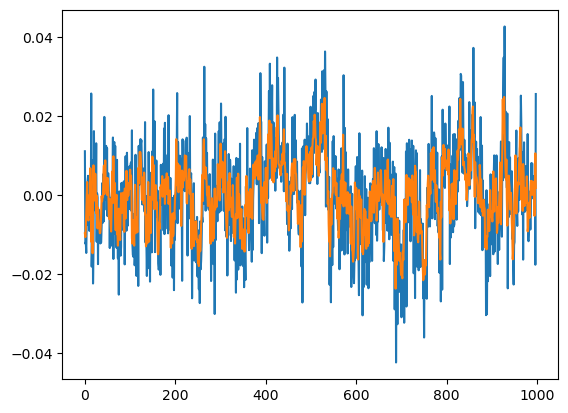

In [71]:
plt.plot(arr[:-n_lags])
# plt.plot(arr_lag)
plt.plot(arr_lag @ true_beta)

In [46]:
with pm.Model() as ar1:
    # assumes 95% of prob mass is between -2 and 2
    rho = pm.Normal("rho", mu=0.0, sigma=1.0, shape=n_lags)
    
    # precision of the innovation term
    tau = pm.Exponential("tau", lam=0.5)

    likelihood = pm.AR("y", rho=rho, tau=tau, constant=True, init_dist=pm.Normal.dist(0, 10), observed=arr)
    
    idata = pm.sample(1000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rho, tau]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 64 seconds.


''

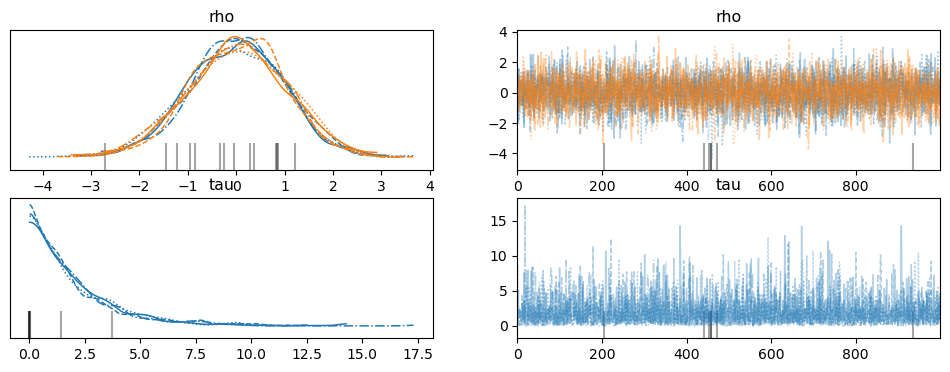

In [47]:
az.plot_trace(idata)
;

In [51]:
post = arr_lag @ idata.posterior.rho[:, get_samp(1000)].values.reshape(4 * 100, true_beta.shape[0], true_beta.shape[1])

''

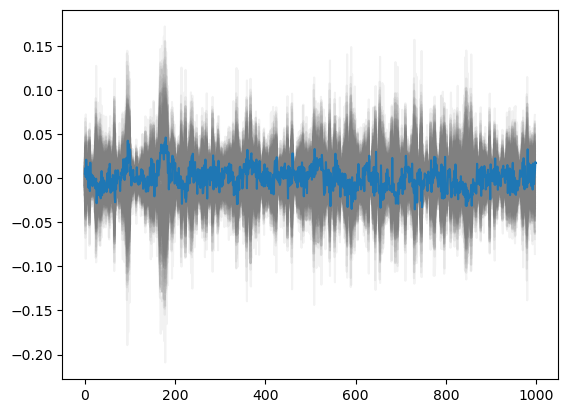

In [52]:
plt.plot(post[:, :, 0].T, alpha=.1, color='grey')
plt.plot(arr)
;

In [55]:
arr_lag = get_VAR_arr(arr, n_lags)
obs = arr[:-n_lags]
coords = {'n_lags': range(0, n_lags), 'n_vars': range(0, n_vars), 'n_var_lags': range(0, n_vars*n_lags), 'time': range(0, len(arr_lag))}

In [73]:
with pm.Model(coords=coords) as VAR:
    alpha = pm.Normal('alpha', mu=0, sigma=1, dims=('n_vars'))
    beta = pm.Normal('beta', mu=0, sigma=1, dims=('n_lags'))
    sigma = pm.HalfNormal("sigma", sigma=0.05)
    
    mu = alpha + arr_lag @ beta
    pm.Normal('likelihood', mu=mu, sigma=sigma, observed=obs.T)
    
    idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 61 seconds.


''

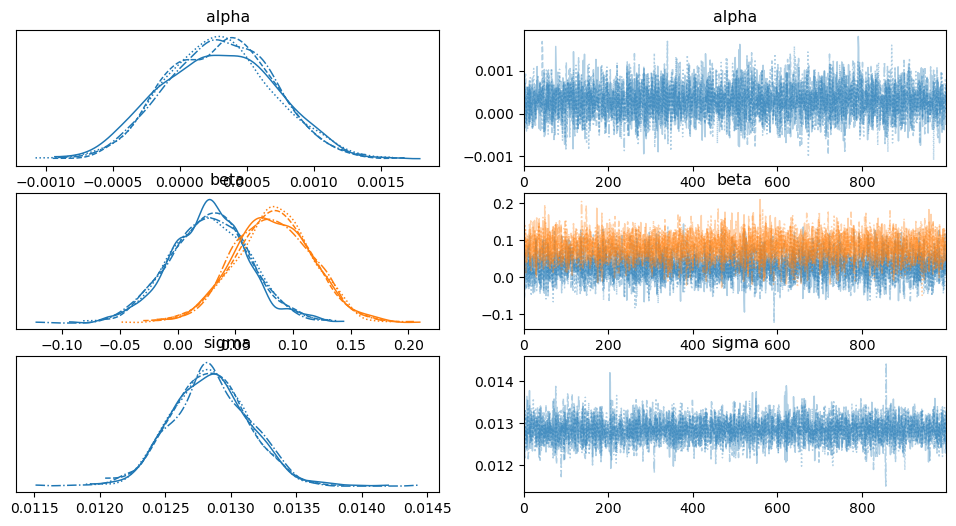

In [74]:
az.plot_trace(idata)
;

In [75]:
post = arr_lag @ idata.posterior.beta[:, get_samp(1000)].values.reshape(4 * 100, true_beta.shape[0], true_beta.shape[1])

In [76]:
post.shape

(400, 998, 1)

''

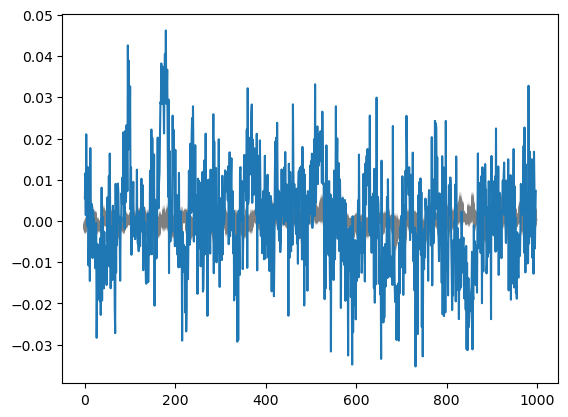

In [77]:
plt.plot(post[:, :, 0].T, color='grey', alpha=.1)
plt.plot(obs)
;

In [79]:
true_alpha

array([1])

''

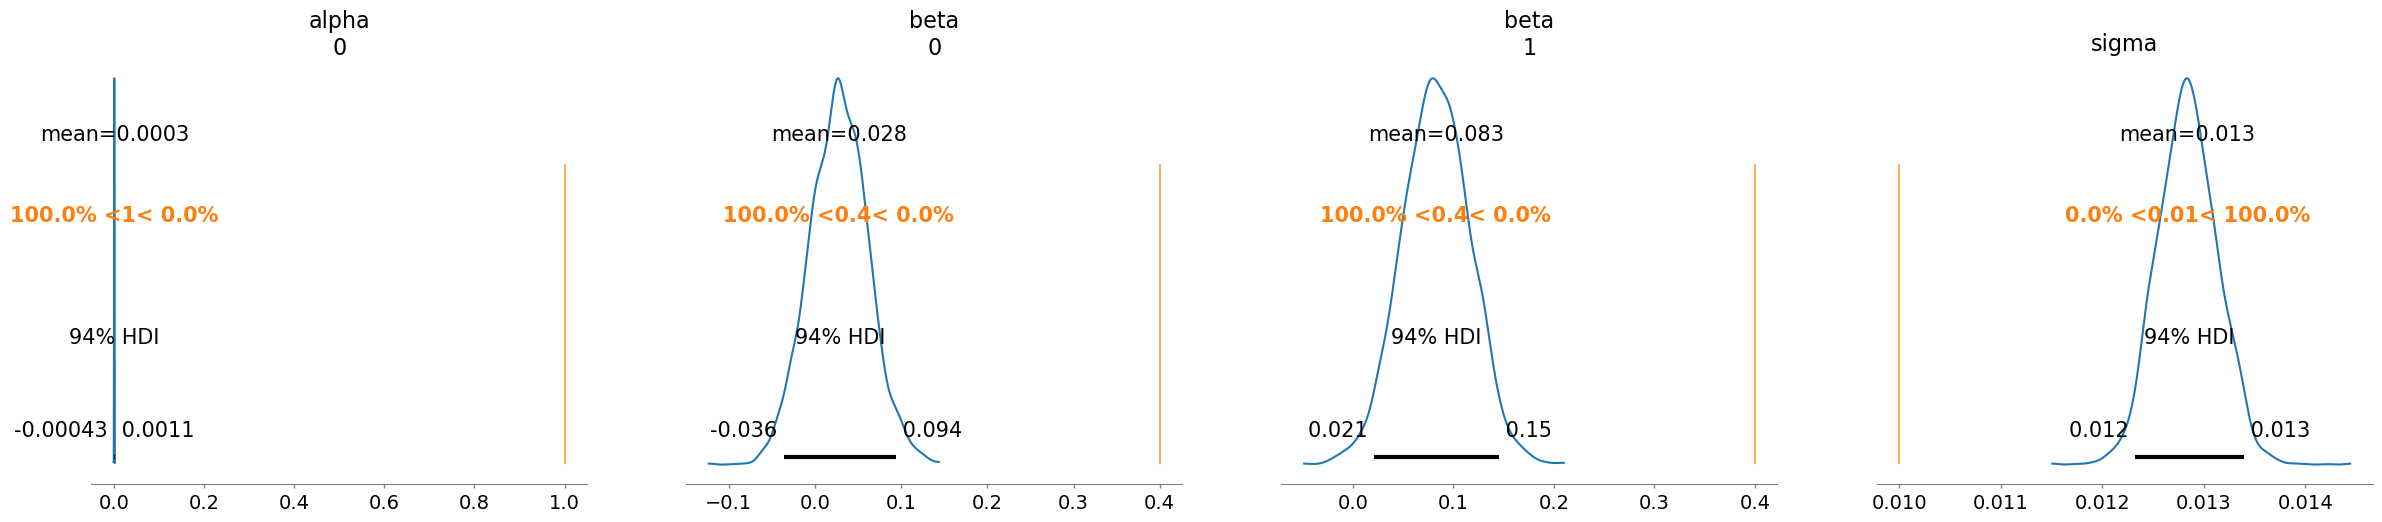

In [78]:
az.plot_posterior(idata, 
                  # var_names=[*chain(*[*[[f'{coef}_{i}' for i in range(1, lstr_lags+1)] for coef in ['phi', 'psi']],  ['alpha', 'gamma', 'c', 'sigma']])],
                  # var_names=['phi', 'psi', 'alpha', 'gamma', 'c', 'sigma'],
                  var_names=['alpha', 'beta', 'sigma'],
                  ref_val=[*true_alpha.ravel(), *true_beta.ravel(), true_sigma]
                 )
;

In [24]:
with pm.Model(coords=coords) as VAR:
    Theta = pm.Normal('Theta', mu=0, sigma=1, dims=('n_var_lags', 'n_vars'))
    alpha = pm.Normal('alpha', mu=0, sigma=1, dims=('n_vars',))
    
    mu = pm.Deterministic("mu", alpha + arr_lag @ Theta)
    
    if len(coords['n_vars']) == 1:
        
        sigma = pm.HalfNormal("sigma", sigma=0.05)
        pm.Normal('likelihood', mu=mu, sigma=sigma, observed=arr[n_lags:-arr_lag.shape[1]], dims=('time', 'n_vars',))
        
    else:
        
        sd_dist = pm.Exponential.dist(1.0, size=len(coords['n_vars']))
        packed_chol = pm.LKJCholeskyCov('sigma_chol', eta=1, n=len(coords['n_vars']), sd_dist=sd_dist, compute_corr=False)
        chol = pm.expand_packed_triangular(n=len(coords['n_vars']), packed=packed_chol, lower=True)
        
        pm.MvNormal('likelihood', mu=mu, chol=chol, dims=('time', 'n_vars',), observed=arr[n_lags:-1])
            

    var_prior_pred = pm.sample_prior_predictive()

Sampling: [Theta, alpha, likelihood, sigma]


''

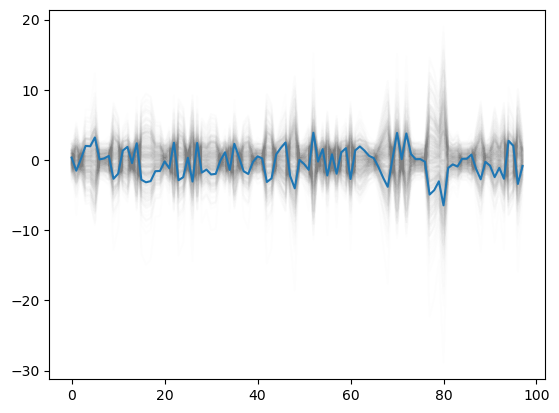

In [27]:
plt.plot(var_prior_pred.prior_predictive.likelihood.values[0, :, :, 0].T, color='grey', alpha=.01)
plt.plot(arr_lag[:, 0])

# plt.plot(var_prior_pred.prior_predictive.likelihood.values[0, :, :, 0].T, color='grey', alpha=.01)
# plt.plot(arr_lag[:, 1])
;

In [28]:
with VAR:
    var_posterior = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Theta, alpha, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 231 seconds.


In [29]:
from src.utils import get_samp

In [30]:
# arr_mod = var_posterior.posterior.alpha[:, get_samp(1000)].values.reshape(4 * 100, arr.shape[1])[:, None, :] + \
arr_mod = arr_lag @ var_posterior.posterior.Theta[:, get_samp(1000)].values.reshape(4 * 100, true_beta.shape[0], true_beta.shape[1])

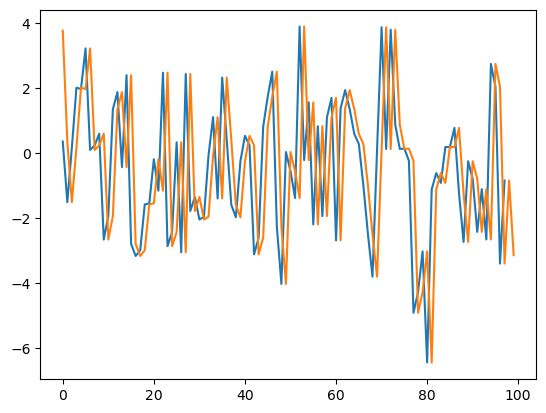

In [53]:
plt.plot(arr_lag)
plt.plot(arr)

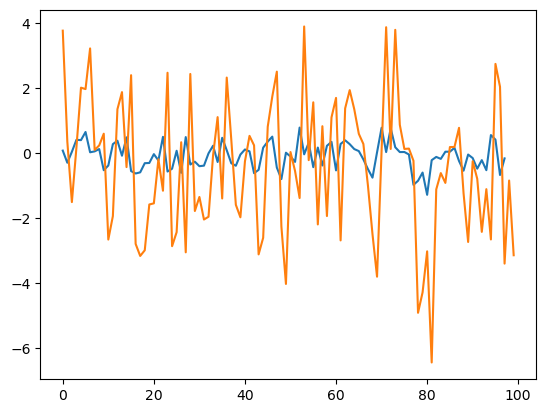

In [51]:
plt.plot(arr_lag @ true_beta)
plt.plot(arr)

In [41]:
var_posterior.posterior.Theta.mean()

<xarray.DataArray 'Theta' ()>
array(1.)

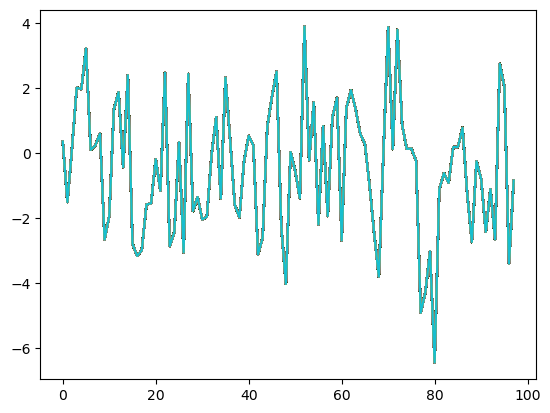

In [38]:
plt.plot(arr_mod[:, :, 0].T);

''

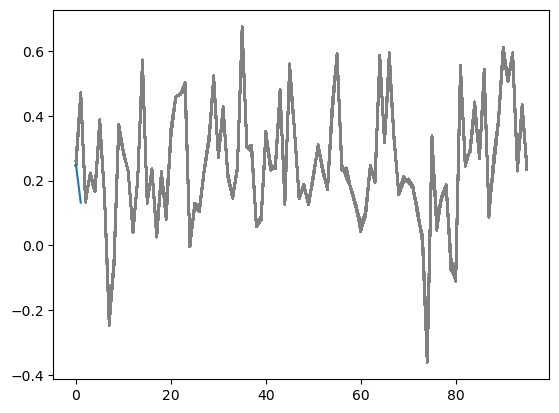

In [343]:
i = 0
plt.plot(
    var_posterior.posterior.mu[:, get_samp(1000)].values.reshape(arr_mod.shape).T[i],
    alpha=.1,
    color='grey'
)
plt.plot(arr[n_lags:][i])
;

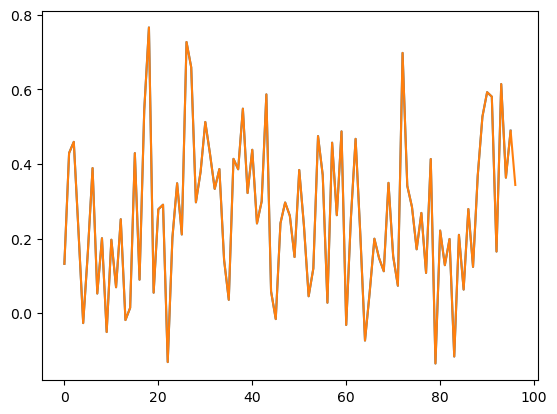

In [340]:
i = 1
plt.plot(var_posterior.observed_data.likelihood[:, i])
plt.plot(arr[n_lags:, i])

## plot posterior outcome

In [ ]:
arr_lagged = get_arr_lagged(arr, n_lags)
samples = [
    [
        idata.posterior.Theta[np.random.randint(0, len(idata.sample_stats.chain)), z].values @ arr_lagged[i] 
        for i in range(arr_lagged.shape[0])
    ]
    for z in np.random.randint(0, len(idata.sample_stats.draw), 100)
]

samples = np.array(samples)

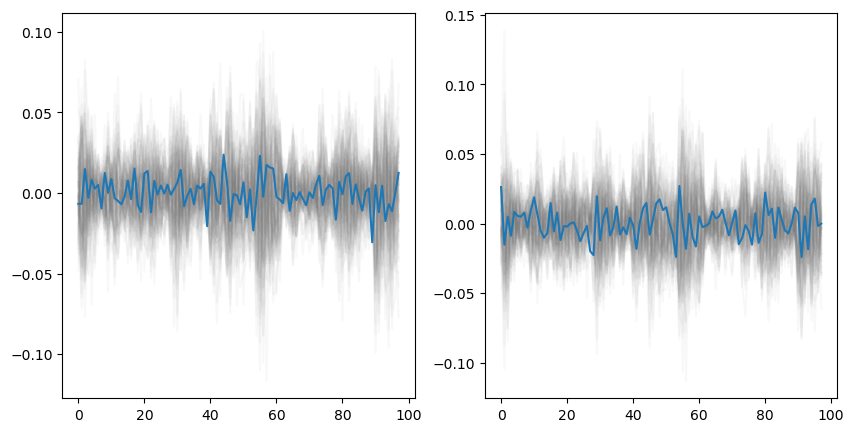

In [186]:
cols = 2
rows = int(np.ceil(n_vars / cols))
fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 5 * rows))
for idx, ax in enumerate(axes.ravel()):
    ax.plot(samples[:, :, idx].transpose(), color='grey', alpha=.05);
    ax.plot(arr[n_lags:, idx])